In [3]:
import zombie_imp
import csv
import serial
import time 
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import pandas as pd
import pywt
import numpy as np
from scipy import stats
import statistics
from scipy.interpolate import interp1d
from sklearn.neighbors import KNeighborsClassifier

In [2]:
# Initialize the Serial port
ser = serial.Serial('COM3', 115200)  # Change the port and baud rate according to transmitter

# create the CSV file
# with open('sensor_data.csv', mode='w', newline='') as file:
#     writer = csv.writer(file)
#     writer.writerow(['Cell 1', 'Cell 2', 'Cell 3'])  

#     # read the data from port and store in CSV file
#     try:
#         while True:
#             data = ser.readline().decode('utf-8', errors='ignore').strip()  # read data from port
#             if data:
#                 values = data.split(' ')  # split with space
#                 if len(values) == 3:  # make sure there are three values
#                     writer.writerow([int(val) for val in values])  # store the data
#     except KeyboardInterrupt:  # stop iteration by Ctrl+C
#         pass

# for one cell
with open('sensor_data.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Sensor Value'])  # 写入表头

    # 循环读取串口数据并写入 CSV 文件
    try:
        while True:
            data = ser.readline().decode('utf-8').strip()  # 从串口读取数据
            if data:
                writer.writerow([int(data)])  # 将传感器值写入CSV文件，不包括时间戳
    except KeyboardInterrupt:  # 当用户按下Ctrl+C时停止循环
        # ser.close()
        pass

In [4]:
# read the csv file
df = pd.read_csv('sensor_data.csv')
# df = pd.read_csv('right_to_left.csv')

# get the data of each solar cell
solar_cell_1 = df['Sensor Value']
# solar_cell_2 = df['Cell 2']
# solar_cell_3 = df['Cell 3']

# apply DWT for the current value of each solar cell
coeffs_1 = pywt.wavedec(solar_cell_1, 'haar', level=4) #coeffs_1[0] contains the first-level approximation coefficient of solar_cell_1, coeffs_1[1] contains the first-level detail coefficient of solar_cell_1
# coeffs_2 = pywt.wavedec(solar_cell_2, 'haar', level=5)
# coeffs_3 = pywt.wavedec(solar_cell_3, 'haar', level=5)

# cA5, cD5, cD4, cD3, cD2, cD1 = coeffs_1

# print("Coefficients for solar_cell_1:", cA5)
# print("Coefficients for solar_cell_2:", coeffs_2)
# print("Coefficients for solar_cell_3:", coeffs_3)

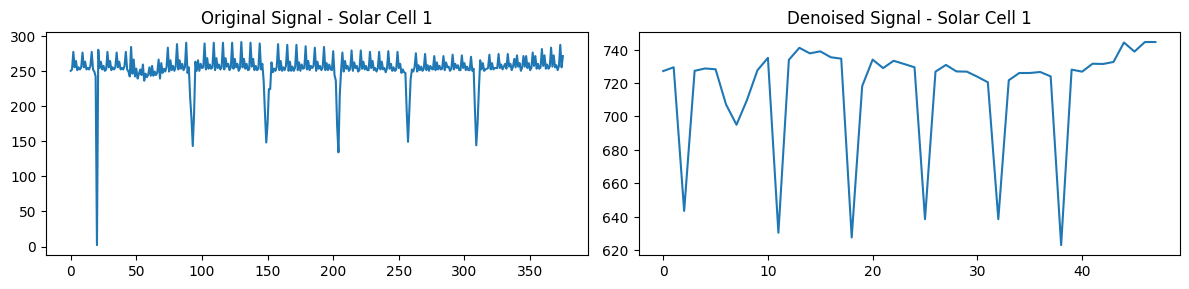

In [5]:
# approx_coeff_1 = stats.zscore(coeffs_1[0])
# detail_coeff_1 = stats.zscore(coeffs_1[1])
approx_coeff_1 = coeffs_1[0]
detail_coeff_1 = coeffs_1[1]
# approx_coeff_2 = coeffs_2[0]
# detail_coeff_2 = coeffs_2[1]
# approx_coeff_3 = coeffs_3[0]
# detail_coeff_3 = coeffs_3[1]

# should be changed based on reality
threshold = 0.4

# apply a threshold on detail coeffcient
detail_coeff_thresh_1 = pywt.threshold(detail_coeff_1, threshold, mode='soft')
# detail_coeff_thresh_2 = pywt.threshold(detail_coeff_2, threshold, mode='soft')
# detail_coeff_thresh_3 = pywt.threshold(detail_coeff_3, threshold, mode='soft')

# reconstruct the signal
coeffs_denoised_1 = [approx_coeff_1, detail_coeff_thresh_1]
solar_cell_denoised_1 = pywt.waverec(coeffs_denoised_1, 'haar')
# coeffs_denoised_2 = [approx_coeff_2, detail_coeff_thresh_2]
# solar_cell_denoised_2 = pywt.waverec(coeffs_denoised_2, 'haar')
# coeffs_denoised_3 = [approx_coeff_3, detail_coeff_thresh_3]
# solar_cell_denoised_3 = pywt.waverec(coeffs_denoised_3, 'haar')


# plot the comparison of single before and after denoising
plt.figure(figsize=(12, 8))

plt.subplot(3, 2, 1)
plt.plot(solar_cell_1)
plt.title('Original Signal - Solar Cell 1')

plt.subplot(3, 2, 2)
plt.plot(solar_cell_denoised_1)
plt.title('Denoised Signal - Solar Cell 1')

# plt.subplot(3, 2, 3)
# plt.plot(solar_cell_2)
# plt.title('Original Signal - Solar Cell 2')

# plt.subplot(3, 2, 4)
# plt.plot(solar_cell_denoised_2)
# plt.title('Denoised Signal - Solar Cell 2')

# plt.subplot(3, 2, 5)
# plt.plot(solar_cell_3)
# plt.title('Original Signal - Solar Cell 3')

# plt.subplot(3, 2, 6)
# plt.plot(solar_cell_denoised_3)
# plt.title('Denoised Signal - Solar Cell 3')

plt.tight_layout()
plt.show()

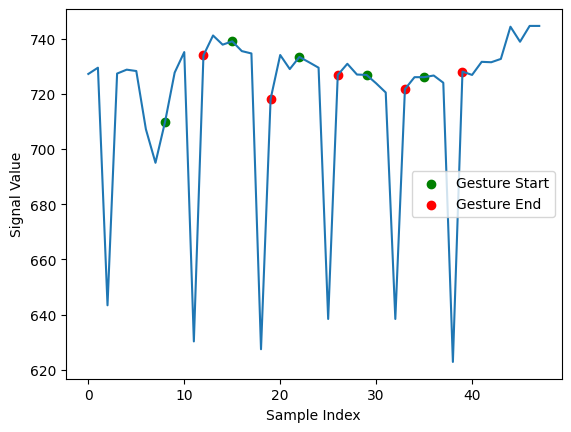

In [6]:
def detect_gesture_starts_ends(signal, window_size, std_threshold, mean_threshold):
    starts = []
    ends = []

    for i in range(len(signal) - window_size):
        window = signal[i:i+window_size]
        std_dev = np.std(window)
        mean = np.mean(window)
        last_sample = window[-1]

        if std_dev < std_threshold and abs(last_sample - mean) > mean_threshold:
            starts.append(i)
            ends.append(i + window_size)

    return starts, ends

# get the start and end points of hand gesture
starts, ends = detect_gesture_starts_ends(solar_cell_denoised_1, 4, 120, 50) 

plt.plot(solar_cell_denoised_1)

# highlight the start and end points
plt.scatter(starts, solar_cell_denoised_1[starts], color='green', label='Gesture Start')
plt.scatter(ends, solar_cell_denoised_1[ends], color='red', label='Gesture End')

plt.xlabel('Sample Index')
plt.ylabel('Signal Value')
plt.legend()

plt.show()


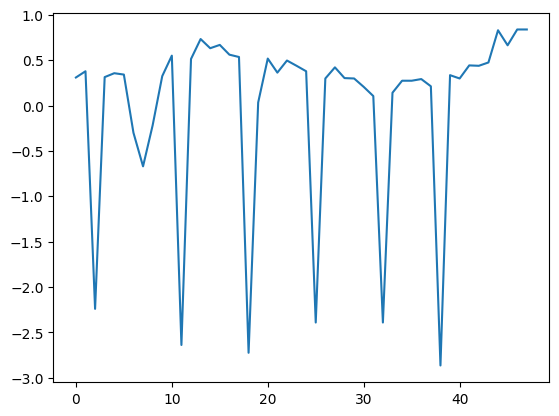

In [7]:
# signal alliment
zscore_1 = stats.zscore(solar_cell_denoised_1)
plt.plot(zscore_1)
plt.show()

In [16]:
def split_time_series(time_series, starts, ends):
    split_sequences = []

    for start, end in zip(starts, ends):
        split_sequences.append(time_series[start:end+1])
    
    return split_sequences

splited_solar_1 = split_time_series(solar_cell_1, starts, ends)
feature_coeffs_1 = []
feature_std_1 = []
target_length = 512 #target window size of interpolate
for solar_slice_1 in splited_solar_1:
    #apply z score transformation on each slice
    zscore_cell1 = stats.zscore(solar_slice_1)
    
    #Apply interpolate on every window (seems not correct)
    current_length = len(zscore_cell1)
    interpolation_factor = target_length / current_length
    original_indices = range(current_length)
    target_indices = [i * interpolation_factor for i in range(target_length)]

    interpolator = interp1d(original_indices, zscore_cell1, kind='linear', fill_value='extrapolate')
    interpolated_solar_slice_1 = interpolator(target_indices)

    # calculate the detail coefficients of each slice
    slice_coeffs_1 = pywt.wavedec(interpolated_solar_slice_1, 'haar', level=5)
    feature_coeffs_1.append(slice_coeffs_1[1])
    std_dev = statistics.stdev(zscore_cell1)
    feature_std_1.append(std_dev)

print(feature_coeffs_1)
print(feature_std_1)

[array([5855.660386  , 5856.49308661, 5856.49308661, 5856.49308661,
       5856.49308661, 5856.49308661, 5856.49308661, 5856.49308661,
       5856.49308661, 5856.49308661, 5856.49308661, 5856.49308661,
       5856.49308661, 5856.49308661, 5856.49308661, 5856.49308661]), array([2739.02661851, 2739.22067689, 2739.22067689, 2739.22067689,
       2739.22067689, 2739.22067689, 2739.22067689, 2739.22067689,
       2739.22067689, 2739.22067689, 2739.22067689, 2739.22067689,
       2739.22067689, 2739.22067689, 2739.22067689, 2739.22067689]), array([7153.10520827, 7154.04088257, 7154.04088257, 7154.04088257,
       7154.04088257, 7154.04088257, 7154.04088257, 7154.04088257,
       7154.04088257, 7154.04088257, 7154.04088257, 7154.04088257,
       7154.04088257, 7154.04088257, 7154.04088257, 7154.04088257]), array([3030.49530746, 3030.84215982, 3030.84215982, 3030.84215982,
       3030.84215982, 3030.84215982, 3030.84215982, 3030.84215982,
       3030.84215982, 3030.84215982, 3030.84215982, 303

In [ ]:

knn_model = KNeighborsClassifier(n_neighbors=3)  # 设置K值
knn_model.fit(X_train, y_train)  # 训练模型